# Two-stage solution

In [1]:
import torch
import torchvision

In [2]:
torch.cuda.empty_cache()
#device = "cpu"
device = "cuda:2" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda:1
Devices count: 4


In [3]:
import pandas
import numpy
import pickle

In [4]:
from pathlib import Path

In [5]:
from misc.data import SimpleClassifierDataset, concatenate_collate_fn, detection_results_to_annotations

In [6]:
from PytorchWildlife.models import detection as pw_detection
from PytorchWildlife.models import classification as pw_classification
from PytorchWildlife.data import transforms as pw_trans
from PytorchWildlife import utils as pw_utils

In [7]:
classifier_model_name = "resnet50"
classifier_weights_name = "ResNet50_Weights"
classifier_weights_subname = "IMAGENET1K_V2"

## Data

In [8]:
data_path = Path("./data/train_data_minprirodi/")
images_path = data_path / "images"
annotation_path = data_path / "annotation.csv"

In [9]:
annotation = pandas.read_csv(annotation_path)
annotation

,Name,Bbox,Class
0,1001958.jpg,"0.7075520833333333,0.5319444444444444,0.282812...",1
1,1001958.jpg,"0.09505208333333333,0.6305555555555555,0.19010...",0
2,1001958.jpg,"0.031510416666666666,0.7434027777777777,0.0630...",0
3,1002155.jpg,"0.8135416666666667,0.6976851851851852,0.371875...",0
4,1002155.jpg,"0.3221354166666667,0.7939814814814815,0.477604...",0
...,...,...,...
1980,1997546.jpg,"0.34661458333333334,0.490625,0.6015625,0.48958...",1
1981,1997602.jpg,"0.7317708333333334,0.25601851851851853,0.30625...",0
1982,1999067.jpg,"0.5630208333333333,0.5020833333333333,0.519791...",1
1983,1999067.jpg,"0.9572916666666667,0.5881944444444445,0.085416...",0


In [10]:
weights = getattr(getattr(torchvision.models, classifier_weights_name), classifier_weights_subname)

In [11]:
dataset = SimpleClassifierDataset(
    images_path,
    annotation,
    torchvision.transforms.Resize((232, 232), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
)

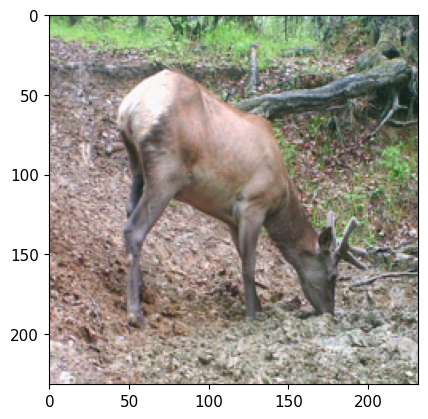

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(dataset[53][0].cpu().detach().numpy().swapaxes(0,2).swapaxes(1,0))
plt.show();

In [13]:
from sklearn.model_selection import train_test_split

unique_names = annotation["Name"].unique()
train_names, test_names = train_test_split(unique_names, test_size=0.2, random_state=42)

In [14]:
train_annotation = annotation[annotation["Name"].isin(train_names)].reset_index(drop=True)
test_annotation  = annotation[annotation["Name"].isin(test_names)].reset_index(drop=True)

In [15]:
train_dataset = SimpleClassifierDataset(images_path, train_annotation, dataset.transform)
test_dataset  = SimpleClassifierDataset(images_path, test_annotation, dataset.transform)

In [16]:
train_batch_size = 128
test_batch_size  = 128

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)#,  collate_fn=concatenate_collate_fn)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=test_batch_size,  shuffle=False)

## Model

In [18]:
from misc.train import *

In [19]:
classifier = getattr(torchvision.models, classifier_model_name)(weights=weights).to(device)

In [20]:
model = Classifier(
    #detector,
    classifier.train(),
    ClassifierHead(1000),
    weights.transforms()
).to(device)

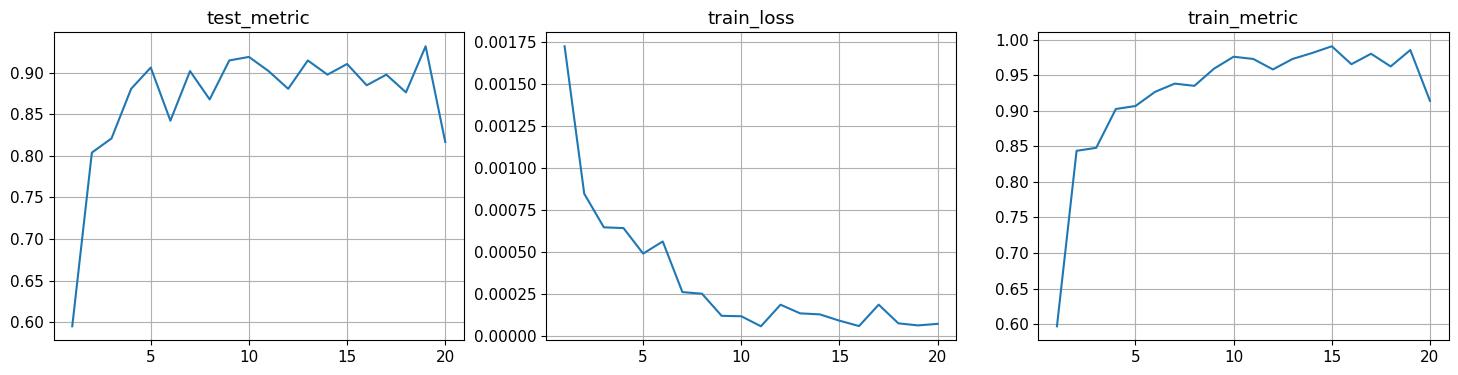

In [21]:
history = train_detector_classifier(
    model,
    train_dataloader,
    test_dataloader,
    torch.optim.Adam(model.parameters(), lr=1.0e-4),
    device,
    n_epochs=20
)

In [22]:
history

defaultdict(list,
            {'train_loss': [0.001726449741847542,
              0.0008465959228939813,
              0.000645679023252377,
              0.0006413679626049332,
              0.0004890901965546039,
              0.0005613214194942897,
              0.0002593035474326111,
              0.00024945743865750666,
              0.00011756061474059987,
              0.00011510643325138421,
              5.5216535260676495e-05,
              0.00018401998004652888,
              0.00013226893855494866,
              0.00012622885476129417,
              8.867821338325926e-05,
              5.658441153092022e-05,
              0.00018434570799903053,
              7.278483903352194e-05,
              6.0424652246237173e-05,
              6.971792766352276e-05],
             'train_metric': [0.596977329974811,
              0.8436188077246012,
              0.8478169605373637,
              0.9023929471032747,
              0.9065910999160369,
              0.9265323257766583,
 